In [2]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import datetime as dt

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

In [117]:
# loading data
path = r"Data\AAPL_options.csv"
options_df = pd.read_csv(path)
options_df.head(2)

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp closing price,date div,exp date div
0,2016-01-04,2016-01-08,call,15.0,11.375,20.0,11.3,12.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377
1,2016-01-04,2016-01-08,put,15.0,0.005,1400.0,0.0,0.0,0.0,0.0,0.0,26.337,24.24,0.085246,0.09377


In [118]:
# creating mid price
options_df.loc[:, "mid price"] = round((options_df["ask price"] + options_df["bid price"])/2, 5)

In [119]:
# concatenating call and put rows for the same price    
# call mid, put mid are columns 16 and 17 respectively
options_df["call mid"] = 0
options_df["put mid"] = 0
    
# boolean masks for call and put options in every second row
call_mask = (options_df.iloc[::2, 2] == "call").values
put_mask = (options_df.iloc[::2, 2] == "put").values

# indices of every second row
indices = np.arange(0, options_df.shape[0], 2)

# assign values based on call options
# if call, call mid will be assigned from mid price and put mid will be assigned from next mid price
options_df.iloc[indices[call_mask], 16] = options_df.iloc[indices[call_mask], 15].values
options_df.iloc[indices[call_mask], 17] = options_df.iloc[indices[call_mask] + 1, 15].values
# assign values based on put options
options_df.iloc[indices[put_mask], 17] = options_df.iloc[indices[put_mask], 15].values
options_df.iloc[indices[put_mask], 16] = options_df.iloc[indices[put_mask] + 1, 15].values

In [120]:
# reducing rows to every other and fixing index
options_df = options_df[options_df.index % 2 == 0]
options_df.index = np.arange(0, len(options_df))

In [121]:
# dropping unnecessary columns
options_df = options_df.drop(["bid price", "ask price", "last price",
     "exp closing price", "date div", "exp date div", "type"], axis=1)

In [122]:
# creating DTE
T = (pd.to_datetime(options_df["expiration date"]) - pd.to_datetime(options_df["date"])).dt.days
options_df["DTE"] = T

In [123]:
# dropping rows with zero call and put mid
mask1 = options_df["call mid"] > 0
mask2 = options_df["put mid"] > 0
options_df = options_df[mask1 | mask2]
options_df.head(2)

,date,expiration date,strike price,ask size,bid size,volume,open interest,closing price,mid price,call mid,put mid,DTE
0,2016-01-04,2016-01-08,15.00,20.0,12.0,0.0,0.0,26.337,11.3375,11.3375,0.0025,4
1,2016-01-04,2016-01-08,16.25,1412.0,0.0,0.0,0.0,26.337,0.0025,10.0875,0.0025,4


In [124]:
# creating new dataframe for date organization
df = pd.DataFrame()

# organizing based on dates
for header in ["DTE", "strike price", "closing price", "call mid", "put mid", "open interest", "volume"]:
    df[header] = options_df.groupby("date")[header].apply(np.array)

# converting index to date column
if "date" not in df.columns:
    df = df.reset_index()

df["date"] = pd.to_datetime(df["date"])
df["terms"] = df["DTE"].apply(lambda x: sorted(set(x)))
df.head(1)

,date,DTE,strike price,closing price,call mid,put mid,open interest,volume,terms
0,2016-01-04,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[11.3375, 10.0875, 8.8375, 7.5875, 6.3375, 5.0...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[0.0, 0.0, 0.0, 0.0, 2592.0, 8.0, 15908.0, 362...","[0.0, 0.0, 0.0, 0.0, 4836.0, 0.0, 35040.0, 157...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,..."


In [125]:
#grouping by DTE
def group_by_dte(dte, val, terms):
    grouped_mask = {}
    for i in terms:
        if i not in grouped_mask:
            grouped_mask[i] = []
        grouped_mask[i] = list(np.array(val)[dte == i])

    return list(grouped_mask.values())

df.loc[:, "strikes by DTE"] = [group_by_dte(row["DTE"], row["strike price"], row["terms"]) for idx, row in df.iterrows()]
df.loc[:, "open interest by DTE"] = [group_by_dte(row["DTE"], row["open interest"], row["terms"]) for idx, row in df.iterrows()]
df.loc[:, "volume by DTE"] = [group_by_dte(row["DTE"], row["volume"], row["terms"]) for idx, row in df.iterrows()]
df.head(2)

,date,DTE,strike price,closing price,call mid,put mid,open interest,volume,terms,strikes by DTE,open interest by DTE,volume by DTE
0,2016-01-04,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[11.3375, 10.0875, 8.8375, 7.5875, 6.3375, 5.0...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[0.0, 0.0, 0.0, 0.0, 2592.0, 8.0, 15908.0, 362...","[0.0, 0.0, 0.0, 0.0, 4836.0, 0.0, 35040.0, 157...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5,...","[[0.0, 0.0, 0.0, 0.0, 2592.0, 8.0, 15908.0, 36...","[[0.0, 0.0, 0.0, 0.0, 4836.0, 0.0, 35040.0, 15..."
1,2016-01-05,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 20.125, 20.25...","[25.677, 25.677, 25.677, 25.677, 25.677, 25.67...","[10.67875, 9.42875, 8.17875, 6.92875, 5.67875,...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 10, 17, 24, 31, 38, 45, 73, 101, 164, 192,...","[[15.0, 16.25, 17.5, 18.75, 20.0, 20.125, 20.2...","[[0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [126]:
#finding ATM strike for each expiration date
def max_by_dte(row):
    return [np.argmax(x) for x in row]

df.loc[:, "max oi index by DTE"] = list(map(max_by_dte, df.loc[:, "open interest by DTE"]))
df.loc[:, "max volume index by DTE"] = list(map(max_by_dte, df.loc[:, "volume by DTE"]))

In [127]:
# finding strike prices with the greatest volume and open interest for each DTE
def max_of(row, col):
    return [row[i][col[i]] for i in range(len(row))]

df.loc[:, "max oi strikes by DTE"] = list(map(max_of, df["strikes by DTE"], df["max oi index by DTE"]))
df.loc[:, "max oi by DTE"] = list(map(max_of, df["open interest by DTE"], df["max oi index by DTE"]))

df.loc[:, "max volume strikes by DTE"] = list(map(max_of, df["strikes by DTE"], df["max volume index by DTE"]))
df.loc[:, "max volume by DTE"] = list(map(max_of, df["open interest by DTE"], df["max volume index by DTE"]))

df.head(1)

,date,DTE,strike price,closing price,call mid,put mid,open interest,volume,terms,strikes by DTE,open interest by DTE,volume by DTE,max oi index by DTE,max volume index by DTE,max oi strikes by DTE,max oi by DTE,max volume strikes by DTE,max volume by DTE
0,2016-01-04,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5, ...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[11.3375, 10.0875, 8.8375, 7.5875, 6.3375, 5.0...","[0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00...","[0.0, 0.0, 0.0, 0.0, 2592.0, 8.0, 15908.0, 362...","[0.0, 0.0, 0.0, 0.0, 4836.0, 0.0, 35040.0, 157...","[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[[15.0, 16.25, 17.5, 18.75, 20.0, 21.25, 22.5,...","[[0.0, 0.0, 0.0, 0.0, 2592.0, 8.0, 15908.0, 36...","[[0.0, 0.0, 0.0, 0.0, 4836.0, 0.0, 35040.0, 15...","[21, 127, 14, 16, 24, 0, 14, 12, 14, 18, 11, 1...","[19, 82, 6, 16, 13, 11, 13, 10, 14, 18, 5, 16,...","[26.25, 35.0, 27.5, 27.5, 28.5, 23.75, 30.0, 2...","[24300.0, 561236.0, 11120.0, 34928.0, 2032.0, ...","[25.75, 27.5, 25.0, 27.5, 25.75, 25.75, 28.75,...","[10868.0, 415412.0, 8404.0, 34928.0, 240.0, 53..."


In [128]:
#reorganizing df
max_df = pd.DataFrame({"date": df["date"],
                       "terms": df["terms"],
                       "close": df["closing price"],
                       "max_volumes": df["max volume by DTE"],
                       "max_ois": df["max oi by DTE"],
                       "max_volume_strikes": df["max volume strikes by DTE"],
                       "max_oi_strikes": df["max oi strikes by DTE"],
                      })
max_df.head(1)

,date,terms,close,max_volumes,max_ois,max_volume_strikes,max_oi_strikes
0,2016-01-04,"[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[10868.0, 415412.0, 8404.0, 34928.0, 240.0, 53...","[24300.0, 561236.0, 11120.0, 34928.0, 2032.0, ...","[25.75, 27.5, 25.0, 27.5, 25.75, 25.75, 28.75,...","[26.25, 35.0, 27.5, 27.5, 28.5, 23.75, 30.0, 2..."


In [129]:
#finding which terms have the highest open interest and volume
#and finding the z score for these terms
def high_val_term(row, val):
    return val[np.argmax(row)]

max_df.loc[:, "max_oi_term"] = list(map(high_val_term, max_df["max_ois"], max_df["terms"]))
max_df.loc[:, "max_volume_term"] = list(map(high_val_term, max_df["max_volumes"], max_df["terms"]))

max_df.loc[:, "max_oi"] = list(map(lambda x: np.max(x), max_df["max_ois"]))
max_df.loc[:, "max_volume"] = list(map(lambda x: np.max(x), max_df["max_volumes"]))

print(max_df[["max_oi_term", "max_volume_term"]])

     max_oi_term  max_volume_term
0             11               11
1             10              381
2              9                9
3              8                8
4              7              287
..           ...              ...
247           28               28
248           24               24
249           23               23
250           22               22
251           21              385

[252 rows x 2 columns]


In [130]:
max_df.loc[:, "max_oi_date"] = list(map(lambda date, term: date + timedelta(term), max_df["date"], max_df["max_oi_term"]))
max_df.loc[:, "max_volume_date"] = list(map(lambda date, term: date + timedelta(term), max_df["date"], max_df["max_volume_term"]))
max_df.head(2)

,date,terms,close,max_volumes,max_ois,max_volume_strikes,max_oi_strikes,max_oi_term,max_volume_term,max_oi,max_volume,max_oi_date,max_volume_date
0,2016-01-04,"[4, 11, 18, 25, 32, 39, 46, 74, 102, 165, 193,...","[26.337, 26.337, 26.337, 26.337, 26.337, 26.33...","[10868.0, 415412.0, 8404.0, 34928.0, 240.0, 53...","[24300.0, 561236.0, 11120.0, 34928.0, 2032.0, ...","[25.75, 27.5, 25.0, 27.5, 25.75, 25.75, 28.75,...","[26.25, 35.0, 27.5, 27.5, 28.5, 23.75, 30.0, 2...",11,11,561236.0,415412.0,2016-01-15,2016-01-15
1,2016-01-05,"[3, 10, 17, 24, 31, 38, 45, 73, 101, 164, 192,...","[25.677, 25.677, 25.677, 25.677, 25.677, 25.67...","[34836.0, 135668.0, 7064.0, 39544.0, 944.0, 35...","[59132.0, 558720.0, 13116.0, 39544.0, 3708.0, ...","[26.5, 26.25, 26.25, 27.5, 26.25, 25.75, 26.25...","[27.5, 35.0, 27.5, 27.5, 22.5, 25.75, 28.75, 2...",10,381,558720.0,190776.0,2016-01-15,2017-01-20


In [131]:
max_df.loc[:, "max_oi_strike"] = list(map(lambda strikes, vals: strikes[np.argmax(vals)], max_df["max_oi_strikes"], max_df["max_ois"]))
max_df.loc[:, "max_volume_strike"] = list(map(lambda strikes, vals: strikes[np.argmax(vals)], max_df["max_volume_strikes"], max_df["max_volumes"]))

max_df[["max_oi_strike", "max_volume_strike"]].head(10)

,max_oi_strike,max_volume_strike
0,35.0,27.5
1,35.0,27.5
2,35.0,25.0
3,30.0,25.0
4,30.0,32.5
5,30.0,25.0
6,30.0,25.0
7,30.0,25.0
8,30.0,25.0
9,30.0,32.5


In [132]:
max_df.iloc[:, 13]

0      35.00
1      35.00
2      35.00
3      30.00
4      30.00
       ...  
247    28.75
248    28.75
249    28.75
250    28.75
251    27.50
Name: max_oi_strike, Length: 252, dtype: float64

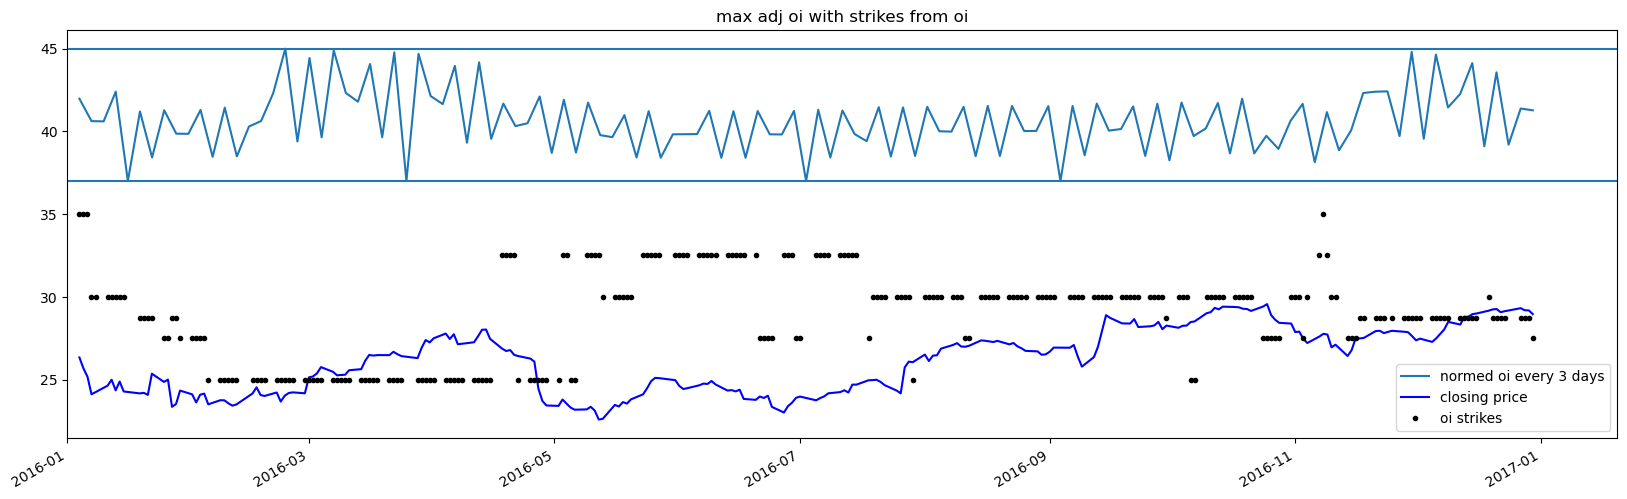

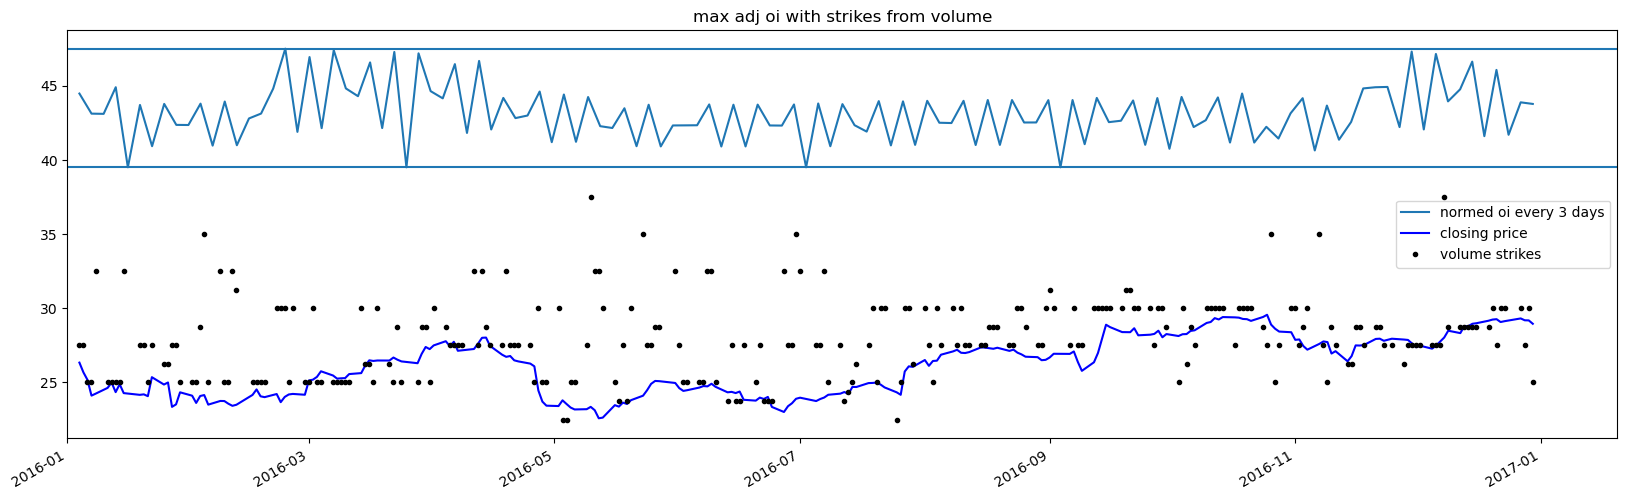

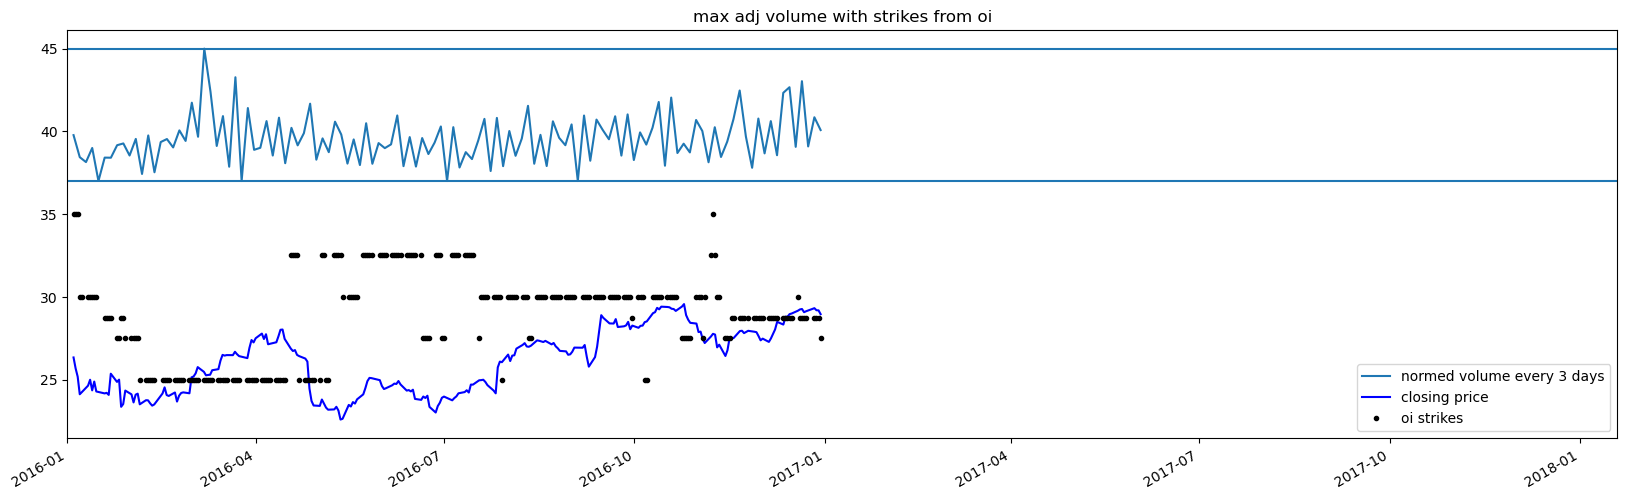

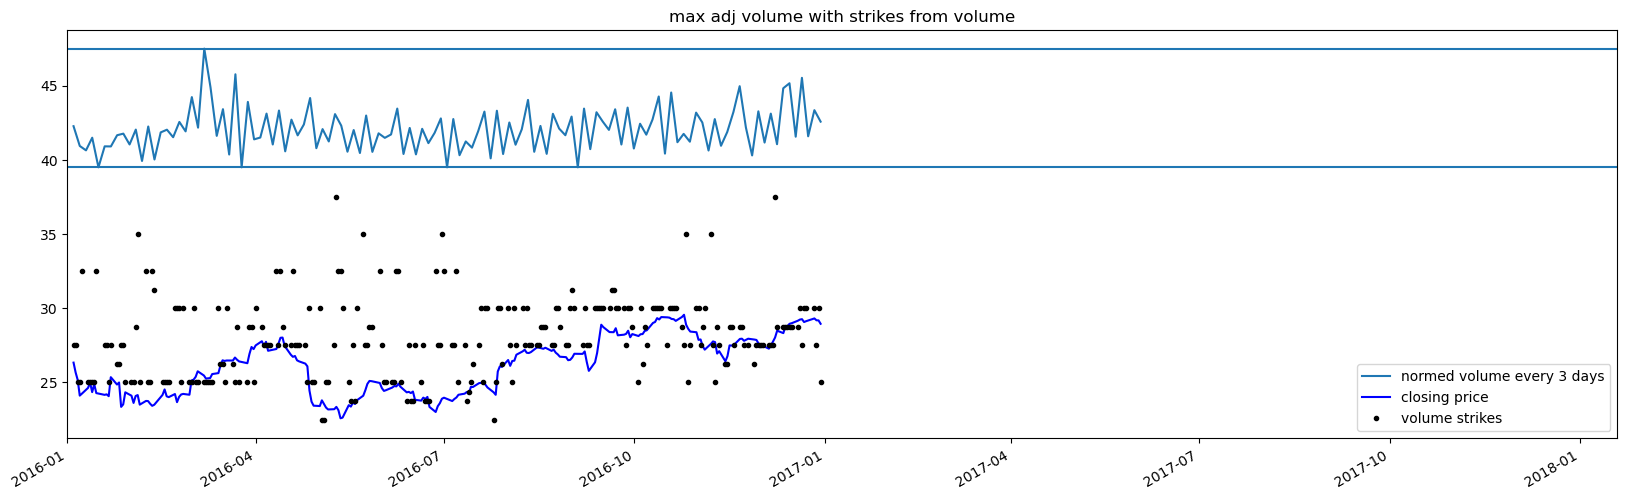

date
2016-01-04     923588.0
2016-01-07     479604.0
2016-01-10     380912.0
2016-01-13     664988.0
2016-01-16          0.0
                ...    
2016-12-17     687784.0
2016-12-20    2009312.0
2016-12-23     696148.0
2016-12-26    1283240.0
2016-12-29    1025688.0
Freq: 3D, Name: max_volume, Length: 121, dtype: float64


In [133]:
def minmaxnorm(arr, a=0, b=1):
    res = a + (b-a) * (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return res

def ma(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    res = ret / n
    res[0] = 25
    return res

# plt.figure(figsize=(20,6))
# plt.plot(date_range, minmaxnorm(grouped_df, 32, 38), label="normed volume every 3 days")
# plt.plot(df["date"], [x[0] for x in df["closing price"]], label="closing price", color="blue")
# plt.plot(df["date"], max_df["max_volume_strike"], "k.", label="strike")
# plt.xlim([dt.date(2016, 1, 1), max_df["max_volume_date"].iloc[-1]])
# plt.axhline(32)
# plt.axhline(38)
# plt.gcf().autofmt_xdate()
# plt.legend()
# plt.show()

names = ["oi", "volume"]



for i in range(2):
    for j in range(2):

        max_val = np.max(max_df.iloc[:, 13+j]) if np.max(max_df.iloc[:, 13+j]) > np.max([x[0] for x in df["closing price"]]) else np.max([x[0] for x in df["closing price"]])
        min_val = np.min(max_df.iloc[:, 13+j]) if np.min(max_df.iloc[:, 13+j]) > np.min([x[0] for x in df["closing price"]]) else np.min([x[0] for x in df["closing price"]])

        grouped_df = max_df.groupby(pd.Grouper(key='date', freq='3D'))[f"max_{names[i]}"].sum()
        date_range = pd.date_range(df["date"].iloc[0], df["date"].iloc[-1], periods=len(minmaxnorm(grouped_df, max_val, max_val+5)))

    
        plt.figure(figsize=(20,6))
        plt.plot(date_range, minmaxnorm(grouped_df, max_val+2, max_val+10), label=f"normed {names[i]} every 3 days")
        plt.plot(df["date"], [x[0] for x in df["closing price"]], label="closing price", color="blue")
        plt.plot(df["date"], max_df.iloc[:, 13+j], "k.", label=f"{names[j]} strikes")
        plt.xlim([dt.date(2016, 1, 1), max_df.iloc[:, 11+i].iloc[-1]])
        plt.title(f"max adj {names[i]} with strikes from {names[j]}")
        plt.axhline(max_val+2)
        plt.axhline(max_val+10)
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.show()

print(grouped_df)

In [ ]:
# less noise for strike prices and volume

In [45]:
v = np.zeros(3)
a = np.array([1,2,3])
np.concatenate(v,a)

TypeError: only integer scalar arrays can be converted to a scalar index